# Imports 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime 
from sklearn.model_selection import train_test_split

# Import the autocorrelation function (ACF) plot.
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from sklearn.svm import SVR


from sklearn.preprocessing import StandardScaler

In [6]:
data = pd.read_pickle('clean_daily_oc.pkl')

In [7]:
data.shape

(3651, 14)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3651 entries, 2011-07-31 to 2021-08-17
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day_of_week_1   3651 non-null   uint8  
 1   day_of_week_2   3651 non-null   uint8  
 2   day_of_week_3   3651 non-null   uint8  
 3   day_of_week_4   3651 non-null   uint8  
 4   day_of_week_5   3651 non-null   uint8  
 5   day_of_week_6   3651 non-null   uint8  
 6   is_holiday_1    3651 non-null   uint8  
 7   Open_pct        3651 non-null   float64
 8   Close_pct       3651 non-null   float64
 9   Volume_diff     3651 non-null   float64
 10  Open_pct_l1     3651 non-null   float64
 11  Close_pct_l1    3651 non-null   float64
 12  Volume_diff_l1  3651 non-null   float64
 13  direction       3651 non-null   object 
dtypes: float64(6), object(1), uint8(7)
memory usage: 253.1+ KB


In [9]:
# define X and y 
X= data.drop(columns=['Open_pct','Close_pct','Volume_diff','direction'])
y= data['Open_pct']

In [10]:
# test train split 
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,shuffle=False)

In [13]:
# Scale data 
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [17]:
# check sizes of train and test sets 
Xs_train.shape,Xs_test.shape

((2920, 10), (731, 10))

# Linear Regression 


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [19]:
# Instantiate and fit linreg model 
linreg = LinearRegression().fit(Xs_train,y_train)

In [175]:
def get_metrics(model,X_train=Xs_train,X_test=Xs_test):
    'MSE on unscaled data'
    # get predictions 
    train_preds= model.predict(X_train)
    test_preds= model.predict(X_test)
    # invert back to original scale 
    #inv_train_preds = ss.inverse_transform(train_preds)
    #inv_test_preds = ss.inverse_transform(test_preds)
    # calculate MSE 
    train_mse = mean_squared_error(y_train,train_preds)
    test_mse= mean_squared_error(y_test,test_preds)
    
    print(f'Training MSE: {train_mse}')
    print(f'Testing MSE: {test_mse}')
    print(f'Test - Train(overage): {(test_mse)-(train_mse)}')
    return 

def get_metrics(model):
    # get predictions 
    train_preds= model.predict(Xs_train)
    test_preds= model.predict(Xs_test)
    # invert back to original scale 
    inv_train_preds = ss.inverse_transform(train_preds)
    inv_test_preds = ss.inverse_transform(test_preds)
    # calculate MSE 
    train_mse = mean_squared_error(y_train,inv_train_preds)
    test_mse= mean_squared_error(y_test,inv_test_preds)
    
    print(f'Training MSE: {train_mse}')
    print(f'Testing MSE: {test_mse}')
    print(f'Test - Train(overage): {(test_mse)-(train_mse)}')
    return 

In [45]:
get_metrics(linreg)

Training MSE: 6.340143414696441e-06
Testing MSE: 8.130747996531363e-05
Test - Train(overage): 7.496733655061718e-05


#  Decision Tree 

In [46]:
from sklearn.tree import DecisionTreeRegressor

In [47]:
# instantiate and fit model 
dt= DecisionTreeRegressor(random_state=42,).fit(Xs_train,y_train)

In [48]:
get_metrics(dt)

Training MSE: 9.091757867318713e-07
Testing MSE: 8.055994576502805e-05
Test - Train(overage): 7.965076997829618e-05


In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

# Bagging Regressor  

In [50]:
from sklearn.ensemble import BaggingRegressor

In [51]:
# instantiate and fit model 
bagreg = BaggingRegressor(bootstrap_features=True,random_state=42).fit(Xs_train,y_train)


In [52]:
get_metrics(bagreg)

Training MSE: 5.091393063401981e-06
Testing MSE: 6.52462619564124e-05
Test - Train(overage): 6.0154868893010426e-05


In [53]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

# Random Forest Regressor

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
# instantiate and fit model 
randfor = RandomForestRegressor(random_state=42).fit(Xs_train,y_train)



In [56]:
# get metrics 
get_metrics(randfor)

Training MSE: 1.7713238591330902e-06
Testing MSE: 6.725446609322385e-05
Test - Train(overage): 6.548314223409075e-05


In [57]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# GradientBoostingRegressor

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

In [59]:
# instantiate and fit model 
gbr = GradientBoostingRegressor(random_state=42,).fit(Xs_train,y_train)

In [61]:
get_metrics(gbr)

Training MSE: 4.40874471535815e-06
Testing MSE: 6.299270715832176e-05
Test - Train(overage): 5.8583962442963614e-05


In [62]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# SVM 

In [63]:
from sklearn.svm import SVR

In [64]:
# instantiate and fit model 
svr = SVR().fit(Xs_train,y_train)

In [65]:
get_metrics(svr)

Training MSE: 0.00015126085217047924
Testing MSE: 0.0002188761185762155
Test - Train(overage): 6.761526640573627e-05


In [66]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

# Feed Forward Neural Network 



In [67]:
from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV

In [68]:
Xs_train.shape

(2920, 10)

In [70]:
# model network 

fnn= Sequential()
fnn.add(Dense(128,activation="relu",input_shape=(10,)))
fnn.add(Dense(64, activation="relu"))
fnn.add(Dense(1))
        
# compile model 
fnn.compile(optimizer='adam',loss='mse',)

# check model 
fnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [71]:
validation_data= (Xs_test,y_test)

In [72]:
hist_fnn = fnn.fit(Xs_train,y_train,epochs=100,validation_data=validation_data,
                  shuffle=False)

Epoch 1/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0036
Epoch 2/100
92/92 [==============================] - 0s 1ms/step - loss: 9.6161e-04 - val_loss: 0.0016
Epoch 3/100
92/92 [==============================] - 0s 1ms/step - loss: 2.6436e-04 - val_loss: 0.0011
Epoch 4/100
92/92 [==============================] - 0s 1ms/step - loss: 1.6487e-04 - val_loss: 9.0141e-04
Epoch 5/100
92/92 [==============================] - 0s 1ms/step - loss: 1.2234e-04 - val_loss: 7.8584e-04
Epoch 6/100
92/92 [==============================] - 0s 1ms/step - loss: 1.0179e-04 - val_loss: 7.3596e-04
Epoch 7/100
92/92 [==============================] - 0s 1ms/step - loss: 9.4889e-05 - val_loss: 6.8557e-04
Epoch 8/100
92/92 [==============================] - 0s 1ms/step - loss: 9.5709e-05 - val_loss: 6.6925e-04
Epoch 9/100
92/92 [==============================] - 0s 1ms/step - loss: 8.0669e-05 - val_loss: 6.4678e-04
Epoch 10/100
92/92 [==============================] -

In [73]:
def plot_loss(hist):
    plt.plot(hist.history['loss'], label='Train MSE')
    plt.plot(hist.history['val_loss'], label='Test MSE')
    plt.legend();

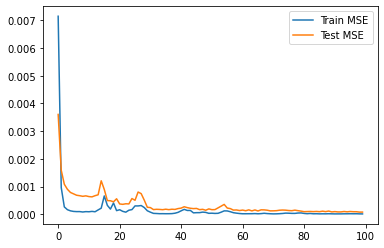

In [74]:
plot_loss(hist_fnn)

In [75]:
get_metrics(fnn)

Training MSE: 1.3602208431510047e-05
Testing MSE: 7.68757353174335e-05
Test - Train(overage): 6.327352688592346e-05


# RNN 

In [76]:
# Create training sequences
train_sequences = TimeseriesGenerator(Xs_train, y_train, length=1,batch_size=64)

# Create Test Sequences
test_sequences = TimeseriesGenerator(Xs_test, y_test, length=1,batch_size=64)

In [77]:
train_sequences[0][0].shape


(64, 1, 10)

In [78]:
input_shape = train_sequences[0][0][0].shape

In [98]:
# model network 

rnn = Sequential()
rnn.add(GRU(20,input_shape=input_shape, return_sequences=True))
rnn.add(GRU(20,return_sequences=False)) # false if next layer dense
rnn.add(Dense(10,activation='relu'))
rnn.add(Dense(1))

# compile model 
rnn.compile(optimizer='adam',loss='mse',)

# show summary 
rnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 1, 20)             1920      
_________________________________________________________________
gru_11 (GRU)                 (None, 20)                2520      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 4,661
Trainable params: 4,661
Non-trainable params: 0
_________________________________________________________________


In [99]:
hist_rnn = rnn.fit(train_sequences,validation_data=test_sequences,
                  epochs=100,verbose=2)

Epoch 1/100
46/46 - 2s - loss: 3.3713e-04 - val_loss: 1.7230e-04
Epoch 2/100
46/46 - 0s - loss: 7.3781e-05 - val_loss: 1.2915e-04
Epoch 3/100
46/46 - 0s - loss: 6.2896e-05 - val_loss: 1.1744e-04
Epoch 4/100
46/46 - 0s - loss: 6.0641e-05 - val_loss: 1.1579e-04
Epoch 5/100
46/46 - 0s - loss: 5.6046e-05 - val_loss: 1.2263e-04
Epoch 6/100
46/46 - 0s - loss: 5.5678e-05 - val_loss: 1.1894e-04
Epoch 7/100
46/46 - 0s - loss: 5.5554e-05 - val_loss: 1.1636e-04
Epoch 8/100
46/46 - 0s - loss: 5.3298e-05 - val_loss: 1.1731e-04
Epoch 9/100
46/46 - 0s - loss: 5.4253e-05 - val_loss: 1.1815e-04
Epoch 10/100
46/46 - 0s - loss: 5.4630e-05 - val_loss: 1.2185e-04
Epoch 11/100
46/46 - 0s - loss: 5.3919e-05 - val_loss: 1.1295e-04
Epoch 12/100
46/46 - 0s - loss: 5.3152e-05 - val_loss: 1.1773e-04
Epoch 13/100
46/46 - 0s - loss: 5.3391e-05 - val_loss: 1.1549e-04
Epoch 14/100
46/46 - 0s - loss: 5.2585e-05 - val_loss: 1.2013e-04
Epoch 15/100
46/46 - 0s - loss: 5.4121e-05 - val_loss: 1.1871e-04
Epoch 16/100
46/46 

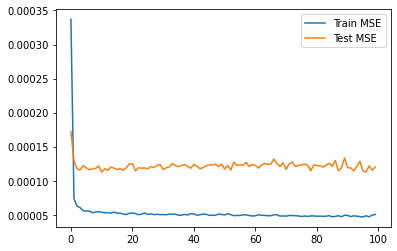

In [100]:
plot_loss(hist_rnn)

In [84]:
# get_metrics(rnn) 

# LSTM 



In [85]:
Xs_train.shape

(2920, 10)

In [88]:
# reshape for LSTM layers 
X_train_lstm= np.reshape(Xs_train,(Xs_train.shape[0],1,Xs_train.shape[1]))
X_test_lstm = np.reshape(Xs_test,(Xs_test.shape[0],1,Xs_test.shape[1]))

In [89]:
X_train_lstm.shape

(2920, 1, 10)

In [90]:
X_test_lstm.shape

(731, 1, 10)

In [104]:
# model network 

lstm = Sequential()
lstm.add(LSTM(30,input_shape=(1,10)))
lstm.add(Dense(20))

# compile model 
lstm.compile(optimizer='adam',loss='mse',)

lstm.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30)                4920      
_________________________________________________________________
dense_19 (Dense)             (None, 20)                620       
Total params: 5,540
Trainable params: 5,540
Non-trainable params: 0
_________________________________________________________________


In [105]:
# fit model 
hist_lstm = lstm.fit(X_train_lstm,y_train,
                     validation_data=(X_test_lstm,y_test),
                  epochs=100,verbose=2)

Epoch 1/100
92/92 - 1s - loss: 0.0025 - val_loss: 8.5395e-04
Epoch 2/100
92/92 - 0s - loss: 2.3922e-04 - val_loss: 3.2509e-04
Epoch 3/100
92/92 - 0s - loss: 8.6110e-05 - val_loss: 2.1321e-04
Epoch 4/100
92/92 - 0s - loss: 5.0035e-05 - val_loss: 1.6316e-04
Epoch 5/100
92/92 - 0s - loss: 3.4277e-05 - val_loss: 1.3592e-04
Epoch 6/100
92/92 - 0s - loss: 2.5560e-05 - val_loss: 1.2372e-04
Epoch 7/100
92/92 - 0s - loss: 2.0400e-05 - val_loss: 1.1077e-04
Epoch 8/100
92/92 - 0s - loss: 1.7167e-05 - val_loss: 1.0314e-04
Epoch 9/100
92/92 - 0s - loss: 1.4958e-05 - val_loss: 9.6959e-05
Epoch 10/100
92/92 - 0s - loss: 1.3248e-05 - val_loss: 9.2481e-05
Epoch 11/100
92/92 - 0s - loss: 1.2144e-05 - val_loss: 9.0301e-05
Epoch 12/100
92/92 - 0s - loss: 1.1240e-05 - val_loss: 8.6043e-05
Epoch 13/100
92/92 - 0s - loss: 1.0541e-05 - val_loss: 8.4739e-05
Epoch 14/100
92/92 - 0s - loss: 9.9687e-06 - val_loss: 8.4806e-05
Epoch 15/100
92/92 - 0s - loss: 9.6782e-06 - val_loss: 8.0996e-05
Epoch 16/100
92/92 - 0s

In [186]:
pd.DataFrame(hist_lstm.history).sort_values(by='val_loss')

,loss,val_loss
95,0.000007,0.000061
97,0.000007,0.000063
98,0.000007,0.000063
99,0.000007,0.000064
82,0.000007,0.000064
...,...,...
4,0.000034,0.000136
3,0.000050,0.000163
2,0.000086,0.000213
1,0.000239,0.000325


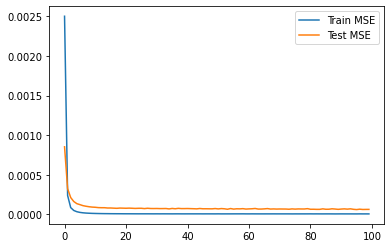

In [106]:
plot_loss(hist_lstm)

In [179]:
# get_metrics(lstm,X_train=X_train_lstm,X_test=X_test_lstm) FIX THIS 

## Baysian Search 

In [107]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
Integer()

In [112]:
# function to make models 
def func_lstm_model(nodes_lstm,nodes_dense):
    model = Sequential()
    model.add(LSTM(nodes_lstm,input_shape=(1,10)))
    model.add(Dense(nodes_dense,activation='relu'))
    model.add(Dense(3,))
    model.compile(optimizer='adam',loss='mse',)
    return model 

In [141]:
lstm_modeler = KerasRegressor(build_fn=func_lstm_model,epochs=50,verbose=1)

In [142]:
search_space_lstm = {
    'nodes_lstm':Integer(10,100),
    'nodes_dense':Integer(10,100)
}


In [145]:
lstm_bs1 = BayesSearchCV(lstm_modeler,search_space_lstm,n_iter=500,random_state=42,verbose=2,)

In [146]:
#lstm_bs1.fit(X_train_lstm,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] nodes_dense=47, nodes_lstm=75 ...................................
Epoch 1/50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 2ms/step - loss: 2.3063e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.6507e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.6300e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4767e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2676e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2054e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2565e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1792e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1407e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0937e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0702e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1432e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


73/73 [==============================] - 2s 2ms/step - loss: 3.0451e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.5842e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.7027e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4980e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2620e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2326e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1464e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2806e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2138e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2341e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1687e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1370e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 2ms/step - loss: 2.2185e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.0306e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4274e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1103e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1295e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0849e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1884e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2045e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 2.2840e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 2.5763e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.6235e-05
Epoch 12/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2293e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


73/73 [==============================] - 1s 2ms/step - loss: 1.8716e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.2789e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.6098e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.5031e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3903e-05
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 1.4969e-05
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 1.5080e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4358e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3918e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.5374e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.9158e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.7550e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 2ms/step - loss: 1.9881e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.3645e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.5606e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4301e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2948e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2919e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3156e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2344e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1450e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0384e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3312e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2590e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


73/73 [==============================] - 1s 2ms/step - loss: 4.3302e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.6460e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.7932e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.7854e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3126e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1926e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1717e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1604e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1636e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0711e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2257e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2340e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 2ms/step - loss: 4.5667e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 3.9655e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 2.3046e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.6697e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3836e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2107e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0949e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0410e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 9.7592e-06
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 9.4816e-06
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 9.0020e-06
Epoch 12/50
73/73 [==============================] - 0s 3ms/step - loss: 9.4768e-06
Epoch 13/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


73/73 [==============================] - 1s 2ms/step - loss: 5.6303e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 4.9840e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 2.8962e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 2.0683e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.6509e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4027e-05
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2168e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1435e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1199e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0412e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 9.7374e-06
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 9.7505e-06
Epoch 13/50


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 2ms/step - loss: 4.0466e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.9634e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 2.0042e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4884e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3442e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2371e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1380e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0396e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 9.8683e-06
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0089e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 9.5952e-06
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0231e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


73/73 [==============================] - 1s 2ms/step - loss: 2.9387e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 3.4552e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 2.0854e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.5810e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3703e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2884e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1723e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1804e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1397e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0916e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0288e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1802e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 3ms/step - loss: 2.1432e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.1886e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4860e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2674e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1003e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0797e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0816e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0553e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1446e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2078e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1059e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.8938e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


73/73 [==============================] - 1s 2ms/step - loss: 3.5022e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.4130e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.8479e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3676e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2982e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3627e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2304e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2441e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1641e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4277e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4361e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.8585e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 2ms/step - loss: 2.3196e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.1218e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4480e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3286e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3053e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2577e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2485e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1647e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2844e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1445e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1670e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2678e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


73/73 [==============================] - 1s 2ms/step - loss: 2.9722e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.4347e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.6728e-05
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 1.5948e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3630e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2187e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1871e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2193e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 2.2511e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 2.3336e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4007e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1674e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 2ms/step - loss: 1.3716e-04
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 1.7479e-05
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 1.5349e-05
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2727e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1739e-05
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2382e-05
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1206e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2510e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2570e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2236e-05
Epoch 11/50
73/73 [==============================] - 0s 3ms/step - loss: 2.0266e-05
Epoch 12/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1999e-05
Epoch 13/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


73/73 [==============================] - 1s 2ms/step - loss: 3.9427e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.8545e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.8714e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4368e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2934e-05
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2112e-05
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1411e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1109e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0302e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1886e-05
Epoch 11/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4996e-05
Epoch 12/50
73/73 [==============================] - 0s 2ms/step - loss: 1.6838e-05
Epoch 13/50


KeyboardInterrupt: 

## Randomized Search 


In [148]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [149]:
# function to make models 
def func_lstm_model(nodes_lstm,nodes_dense):
    model = Sequential()
    model.add(LSTM(nodes_lstm,input_shape=(1,10)))
    model.add(Dense(nodes_dense,activation='relu'))
    model.add(Dense(3,))
    model.compile(optimizer='adam',loss='mse',)
    return model 

In [155]:
lstm_modeler = KerasRegressor(build_fn=func_lstm_model,epochs=50,verbose=0)

In [156]:
# params = 
params_rs_lstm1 = {
    'nodes_lstm': randint(10,100),
    'nodes_dense': randint(10,100)
}

rs_lstm_1 = RandomizedSearchCV(lstm_modeler,params_rs_lstm1,n_iter=50,random_state=42,verbose=2,cv=2)

# fit 
rs_lstm_1.fit(X_train_lstm,y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] nodes_dense=61, nodes_lstm=24 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... nodes_dense=61, nodes_lstm=24, total=   5.8s
[CV] nodes_dense=61, nodes_lstm=24 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] .................... nodes_dense=61, nodes_lstm=24, total=   6.6s
[CV] nodes_dense=81, nodes_lstm=70 ...................................
[CV] .................... nodes_dense=81, nodes_lstm=70, total=   6.7s
[CV] nodes_dense=81, nodes_lstm=70 ...................................
[CV] .................... nodes_dense=81, nodes_lstm=70, total=   6.6s
[CV] nodes_dense=30, nodes_lstm=92 ...................................
[CV] .................... nodes_dense=30, nodes_lstm=92, total=   6.3s
[CV] nodes_dense=30, nodes_lstm=92 ...................................
[CV] .................... nodes_dense=30, nodes_lstm=92, total=   6.1s
[CV] nodes_dense=96, nodes_lstm=84 ...................................
[CV] .................... nodes_dense=96, nodes_lstm=84, total=   6.1s
[CV] nodes_dense=96, nodes_lstm=84 ...................................
[CV] .................... nodes_dense=96, nodes_lstm=84, total=   6.1s
[CV] nodes_dense=84, nodes_lstm=97 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.1min finished


RandomizedSearchCV(cv=2,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd79c104f40>,
                   n_iter=50,
                   param_distributions={'nodes_dense': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd8e6d2e580>,
                                        'nodes_lstm': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd8086a5f40>},
                   random_state=42, verbose=2)

In [160]:
def rs_results(rs):
    return pd.DataFrame(rs.cv_results_)[['params','mean_test_score']].sort_values(by='mean_test_score',ascending=False).head(10)

In [161]:
rs_results(rs_lstm_1)

,params,mean_test_score
27,"{'nodes_dense': 11, 'nodes_lstm': 93}",-0.000011
34,"{'nodes_dense': 15, 'nodes_lstm': 63}",-0.000011
35,"{'nodes_dense': 13, 'nodes_lstm': 63}",-0.000011
11,"{'nodes_dense': 42, 'nodes_lstm': 85}",-0.000012
7,"{'nodes_dense': 11, 'nodes_lstm': 97}",-0.000012
20,"{'nodes_dense': 12, 'nodes_lstm': 60}",-0.000012
2,"{'nodes_dense': 30, 'nodes_lstm': 92}",-0.000012
32,"{'nodes_dense': 45, 'nodes_lstm': 59}",-0.000012
22,"{'nodes_dense': 82, 'nodes_lstm': 48}",-0.000012
43,"{'nodes_dense': 49, 'nodes_lstm': 94}",-0.000012


In [ ]:
# Make model with best params from search 



In [ ]:
rs_lstm_1

In [163]:
pd.DataFrame(rs_lstm_1.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_nodes_dense', 'param_nodes_lstm', 'params', 'split0_test_score',
       'split1_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

<AxesSubplot:xlabel='param_nodes_dense', ylabel='mean_test_score'>

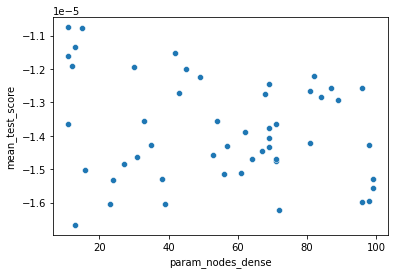

In [171]:
sns.scatterplot(x=pd.DataFrame(rs_lstm_1.cv_results_)['param_nodes_dense'],y=pd.DataFrame(rs_lstm_1.cv_results_)['mean_test_score'])

<AxesSubplot:xlabel='param_nodes_lstm', ylabel='mean_test_score'>

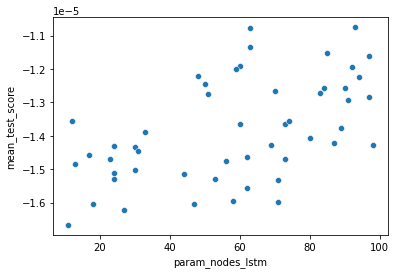

In [172]:
sns.scatterplot(x=pd.DataFrame(rs_lstm_1.cv_results_)['param_nodes_lstm'],y=pd.DataFrame(rs_lstm_1.cv_results_)['mean_test_score'])

In [173]:
# plot on same axis 

In [180]:
# get_metrics(rs_lstm_1)

# Predictions 

- fit best model 
- get predictions 
- use original data to transform predictions to prices 
- plot actual vs predicted 